# <font color = 'red' ><center>Computer Vision Project-2</center></font>

# Part -1

<h4>• DOMAIN: </h4>Entertainment
<h4>• CONTEXT:</h4> Company X owns a movie application and repository which caters movie streaming to millions of users who on subscription basis. Company  wants  to  automate  the  process  of  cast  and  crew  information  in  each  scene  from  a  movie  such  that  when  a  user  pauses  on  the movie and clicks on cast information button, the app will show details of the actor in the scene. Company has an in-house computer vision and multimedia experts who need to detect faces from screen shots from the movie scene.
<h4>• DATA DESCRIPTION: </h4>The dataset comprises of images and its mask where there is a human face.
<h4>• PROJECT OBJECTIVE:</h4> Face detection from training images

In [1]:
#importing importing libraries
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
from numpy import asarray

In [2]:
#import packages of tensorflow and keras 
from tensorflow.keras.layers import Conv2D,Dense,Embedding,Concatenate,UpSampling2D,Input
from tensorflow.keras.layers import Conv2DTranspose,BatchNormalization,Activation,Reshape
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras.losses import BinaryCrossentropy,CategoricalCrossentropy,MAE,MSE,binary_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

#mobilenet
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet import preprocess_input

In [3]:
import random
random.seed(0)

# Ignore the warnings
import warnings
warnings.filterwarnings("ignore")

In [4]:
# loading the dataset
train_data = np.load("D:/Datasets/CV_project2/images.npy",allow_pickle=True)
train_data.shape

(409, 2)

In [5]:
# exploring the data
train_data[0][0]

array([[[42, 37, 34],
        [56, 51, 48],
        [71, 66, 63],
        ...,
        [23, 33, 34],
        [26, 36, 37],
        [28, 38, 39]],

       [[40, 35, 32],
        [51, 46, 43],
        [64, 59, 56],
        ...,
        [27, 36, 35],
        [24, 33, 32],
        [26, 35, 34]],

       [[43, 38, 35],
        [51, 46, 43],
        [61, 56, 53],
        ...,
        [28, 30, 27],
        [33, 35, 32],
        [35, 37, 34]],

       ...,

       [[56, 47, 40],
        [57, 48, 41],
        [61, 52, 45],
        ...,
        [67, 48, 42],
        [55, 35, 28],
        [60, 40, 33]],

       [[53, 44, 37],
        [54, 45, 38],
        [57, 48, 41],
        ...,
        [59, 40, 34],
        [60, 40, 33],
        [54, 34, 27]],

       [[53, 44, 37],
        [54, 45, 38],
        [57, 48, 41],
        ...,
        [59, 40, 34],
        [70, 50, 43],
        [64, 44, 37]]], dtype=uint8)

In [6]:
train_data[3][1]

[{'label': ['Face'],
  'notes': '',
  'points': [{'x': 0.495, 'y': 0.27147766323024053},
   {'x': 0.595, 'y': 0.46048109965635736}],
  'imageWidth': 600,
  'imageHeight': 291}]

(-0.5, 649.5, 332.5, -0.5)

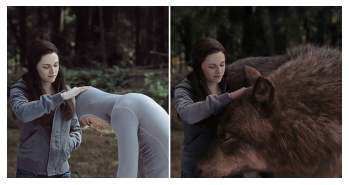

In [7]:
# let us plot the image using matplotlib
plt.imshow(train_data[0][0])
plt.axis('off')

In [8]:
# method will return df 
def get_data(data):
    data_df = pd.DataFrame()
    data = []
    for i in range(len(train_data)):# loop to get info of all images
        for j in range(len(train_data[i][1])):#loop to get all the face details in a image
            coordinates = []
            width = train_data[i][1][j].get('imageWidth')
            height = train_data[i][1][j].get('imageHeight')
            Xmin = train_data[i][1][j].get('points')[0].get('x')
            ymin = train_data[i][1][j].get('points')[0].get('y')
            Xmax = train_data[i][1][j].get('points')[1].get('x')
            ymax = train_data[i][1][j].get('points')[1].get('y')
            coordinates.append(i)
            coordinates.append(j)
            coordinates.append(Xmin)
            coordinates.append(ymin)
            coordinates.append(Xmax)
            coordinates.append(ymax)
            coordinates.append(train_data[i][1][j].get('label')[0])
            coordinates.append(width)
            coordinates.append(height)
            data.append(coordinates)
            
    data_df = pd.DataFrame(data,columns = ['Image_id','Object_id','Xmin','Ymin','Xmax','Ymax','Label','Img_width','Img_height'])        
    return data_df

In [9]:
data_df = get_data(train_data) 
data_df.head()

Image_id  Object_id      Xmin      Ymin      Xmax      Ymax Label  \
0         0          0  0.086154  0.306306  0.172308  0.453453  Face   
1         0          1  0.583077  0.291291  0.658462  0.468468  Face   
2         1          0  0.705309  0.232604  0.769231  0.361829  Face   
3         2          0  0.469565  0.050000  0.606522  0.333333  Face   
4         2          1  0.628261  0.008333  0.745652  0.308333  Face   

   Img_width  Img_height  
0        650         333  
1        650         333  
2       1280         697  
3        460         240  
4        460         240

In [10]:
#lets see what are the labels we have
data_df['Label'].value_counts()

Face    1132
Name: Label, dtype: int64

**Creating features (images) and labels (mask)**

In [11]:
# lets create a masks for all image 

ALPHA = 1 # Width hyper parameter for MobileNet (0.25, 0.5, 0.75, 1.0). Higher width means more accurate but slower

IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224

HEIGHT_CELLS = 28
WIDTH_CELLS = 28

IMAGE_SIZE = 224

masks = np.zeros((int(train_data.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH))
IMAGES = np.zeros((int(train_data.shape[0]),IMAGE_HEIGHT, IMAGE_WIDTH, 3))
for i in range(len(train_data)):
    # making image  size to mask size and adding segmentation 
    img = train_data[i][0]
    img = cv2.resize(img, dsize=(IMAGE_HEIGHT, IMAGE_WIDTH), interpolation=cv2.INTER_CUBIC)
    try:
        img = img[:,:,:3]
    except:
        print(f"Exception {i} Grayscale image with shape {img.shape}")
        # convert the grayscale image to color so that the number of channels are standardized to 3
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        continue
    IMAGES[i] = preprocess_input(np.array(img, dtype=np.float32))# normalizing image by mobilenet 
    for j in range(data_df.loc[data_df['Image_id']== i,'Object_id'].max()+1):
    
        x1 = int(data_df.loc[(data_df['Image_id']== i) & (data_df['Object_id'] == j)]['Xmin'].values[0]*IMAGE_WIDTH)
        x2 = int(data_df.loc[(data_df['Image_id']== i) & (data_df['Object_id'] == j)]['Xmax'].values[0]*IMAGE_WIDTH)
        y1 = int(data_df.loc[(data_df['Image_id']== i) & (data_df['Object_id'] == j)]['Ymin'].values[0]*IMAGE_HEIGHT)
        y2 = int(data_df.loc[(data_df['Image_id']== i) & (data_df['Object_id'] == j)]['Ymax'].values[0]*IMAGE_HEIGHT)
        #print(x1,x2,y1,y2)
        
        masks[i][y1:y2, x1:x2] = 1
print(f"### Shape of X is '{IMAGES.shape}' and the shape of mask is '{masks.shape}' ")


Exception 272 Grayscale image with shape (224, 224)
### Shape of X is '(409, 224, 224, 3)' and the shape of mask is '(409, 224, 224)' 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


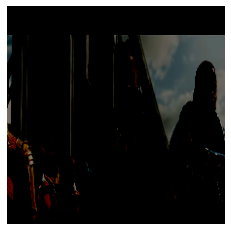

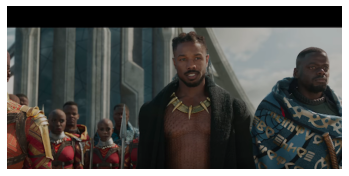

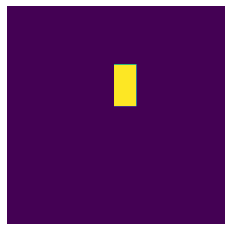

In [12]:
# let us plot the image using matplotlib
plt.imshow(IMAGES[3])
plt.axis('off')
plt.show()
plt.imshow(train_data[3][0])
plt.axis('off')
plt.show()
plt.imshow(masks[3])
plt.axis('off')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


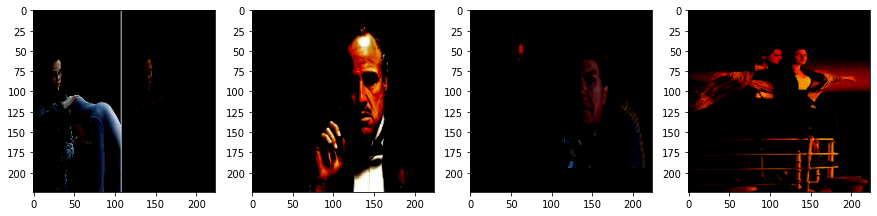

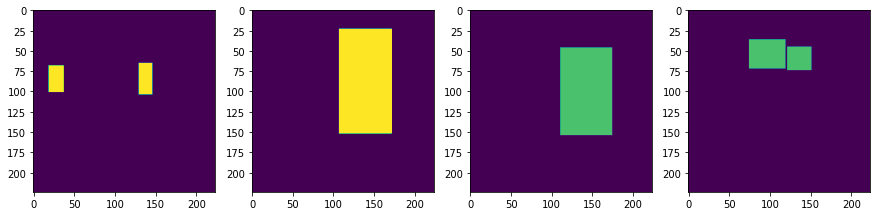

In [13]:
fig = plt.figure(figsize=(15, 15))
a = fig.add_subplot(1, 4, 1)
imgplot = plt.imshow(IMAGES[0])

a = fig.add_subplot(1, 4, 2)
imgplot = plt.imshow(IMAGES[10])
imgplot.set_clim(0.0, 0.7)

a = fig.add_subplot(1, 4, 3)
imgplot = plt.imshow(IMAGES[20])
imgplot.set_clim(0.0, 1.4)

a = fig.add_subplot(1, 4, 4)
imgplot = plt.imshow(IMAGES[30])
imgplot.set_clim(0.0, 2.1)

fig = plt.figure(figsize=(15, 15))
a = fig.add_subplot(1, 4, 1)
imgplot = plt.imshow(masks[0])

a = fig.add_subplot(1, 4, 2)
imgplot = plt.imshow(masks[10])
imgplot.set_clim(0.0, 0.7)

a = fig.add_subplot(1, 4, 3)
imgplot = plt.imshow(masks[20])
imgplot.set_clim(0.0, 1.4)

a = fig.add_subplot(1, 4, 4)
imgplot = plt.imshow(masks[30])
imgplot.set_clim(0.0, 1.4)

**Splitting the data into train and test sets**

In [14]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(IMAGES, masks, test_size=0.2)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.2)

print(f"Shape of X_train is '{X_train.shape}' and the shape of y_train is '{y_train.shape}'")
print(f"Shape of X_val is '{X_val.shape}' and the shape of y_val is '{y_val.shape}'")
print(f"Shape of X_test is '{X_test.shape}' and the shape of y_test is '{y_test.shape}'")

Shape of X_train is '(327, 224, 224, 3)' and the shape of y_train is '(327, 224, 224)'
Shape of X_val is '(65, 224, 224, 3)' and the shape of y_val is '(65, 224, 224)'
Shape of X_test is '(17, 224, 224, 3)' and the shape of y_test is '(17, 224, 224)'


### Creating a Mask Detection Model using U-net with MobileNet Transfer Learning Model

<img src='https://miro.medium.com/max/1400/1*lvXoKMHoPJMKpKK7keZMEA.png'></img>

In [15]:
def create_model(trainable=True):
    inputs = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3), name="input_image")
    model = MobileNetV2(input_tensor=inputs, include_top=False, alpha=ALPHA, weights="imagenet")

    for layer in model.layers:
        layer.trainable = trainable
        
    # Use the activations of these layers
    layer_names = [
        'input_image', #224*224
        'block_1_expand_relu',   # 64x64
        'block_3_expand_relu',   # 32x32
        'block_6_expand_relu',   # 16x16
        ]
    base_model_outputs = [model.get_layer(name).output for name in layer_names]
    x = model.get_layer("block_13_expand_relu").output
    f = [16, 32, 48, 64]
    for i in range(1,len(base_model_outputs)+1):

        x_skip = base_model_outputs[-i]
        x = UpSampling2D((2, 2))(x)
        x = Concatenate()([x, x_skip])
       
        
        x = Conv2D(f[-i], (3, 3), padding="same")(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
        
        x = Conv2D(f[-i], (3, 3), padding="same")(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
        
    x = Conv2D(1, (1, 1), padding="same")(x)
    x = Activation("sigmoid")(x)

    return Model(inputs=model.input, outputs=x)

**Designing Dice Coefficient and Loss function**

In [16]:
def dice_coefficient(y_true, y_pred):
    numerator = 2 * tf.reduce_sum(y_true * y_pred)
    denominator = tf.reduce_sum(y_true + y_pred)

    return numerator / (denominator + tf.keras.backend.epsilon())

def loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - tf.keras.backend.log(dice_coefficient(y_true, y_pred) + 
                                                                              tf.keras.backend.epsilon())

In [17]:
model = create_model(False)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_image[0][0]                
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
______________________________________________________________________________________________

**Compile the model**
* Define optimizer
* Define metrics
* Define loss

In [18]:
optimizer = Adam()
model.compile(loss=loss, optimizer=optimizer, metrics=[dice_coefficient])

In [19]:
#creating call backs
checkpoint = ModelCheckpoint("model-{val_loss:.2f}.h5", monitor="val_loss", verbose=1, save_best_only=True, save_weights_only=True)
stop = EarlyStopping(monitor="val_loss", patience=5)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=5, min_lr=1e-6, verbose=1)

In [20]:
model.fit(X_train, y_train, validation_data = (X_val, y_val), epochs=10, batch_size=32, verbose=1)

Epoch 1/10
11/11 [==============================] - 28s 702ms/step - loss: 1.8069 - dice_coefficient: 0.3258 - val_loss: 8.3098 - val_dice_coefficient: 0.3817
Epoch 2/10
11/11 [==============================] - 4s 371ms/step - loss: 1.2825 - dice_coefficient: 0.4335 - val_loss: 3.5636 - val_dice_coefficient: 0.5051
Epoch 3/10
11/11 [==============================] - 4s 372ms/step - loss: 1.1487 - dice_coefficient: 0.4647 - val_loss: 7.2381 - val_dice_coefficient: 0.3940
Epoch 4/10
11/11 [==============================] - 4s 371ms/step - loss: 1.0667 - dice_coefficient: 0.4780 - val_loss: 4.4151 - val_dice_coefficient: 0.3919
Epoch 5/10
11/11 [==============================] - 4s 371ms/step - loss: 0.9926 - dice_coefficient: 0.4946 - val_loss: 3.3431 - val_dice_coefficient: 0.3921
Epoch 6/10
11/11 [==============================] - 4s 372ms/step - loss: 0.9445 - dice_coefficient: 0.5126 - val_loss: 3.2722 - val_dice_coefficient: 0.4184
Epoch 7/10
11/11 [==============================] -

**Evaluating the Model**

In [21]:
model.evaluate(X_test, y_test)

1/1 [==============================] - 2s 2s/step - loss: 1.5497 - dice_coefficient: 0.3350


[1.5497294664382935, 0.33497828245162964]

**Predicting an image that was not used for training and testing the model**

In [22]:
filename = "D:/Datasets/CV_project2/Part 1Test Data - Prediction Image.jpeg"
unscaled = cv2.imread(filename)
image = cv2.resize(unscaled, (IMAGE_WIDTH, IMAGE_HEIGHT))
feat_scaled = preprocess_input(np.array(image, dtype=np.float32))

In [23]:
y_pred = model.predict(np.array([feat_scaled]))
#y_pred
pred_mask = cv2.resize((1.0*(y_pred[0] > 0.5)), (IMAGE_WIDTH,IMAGE_HEIGHT))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


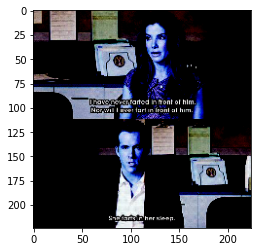

In [24]:
plt.imshow(feat_scaled)

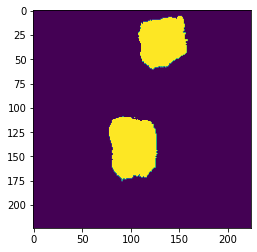

In [25]:
plt.imshow(pred_mask)

# Conclusion
* I used mobileNetV2 for Segmentation
* Refered Unet arc
* Making GOOD prediction
* if we increase epochs may model perform better [due to memory constraint did not perform ]

# Part 2

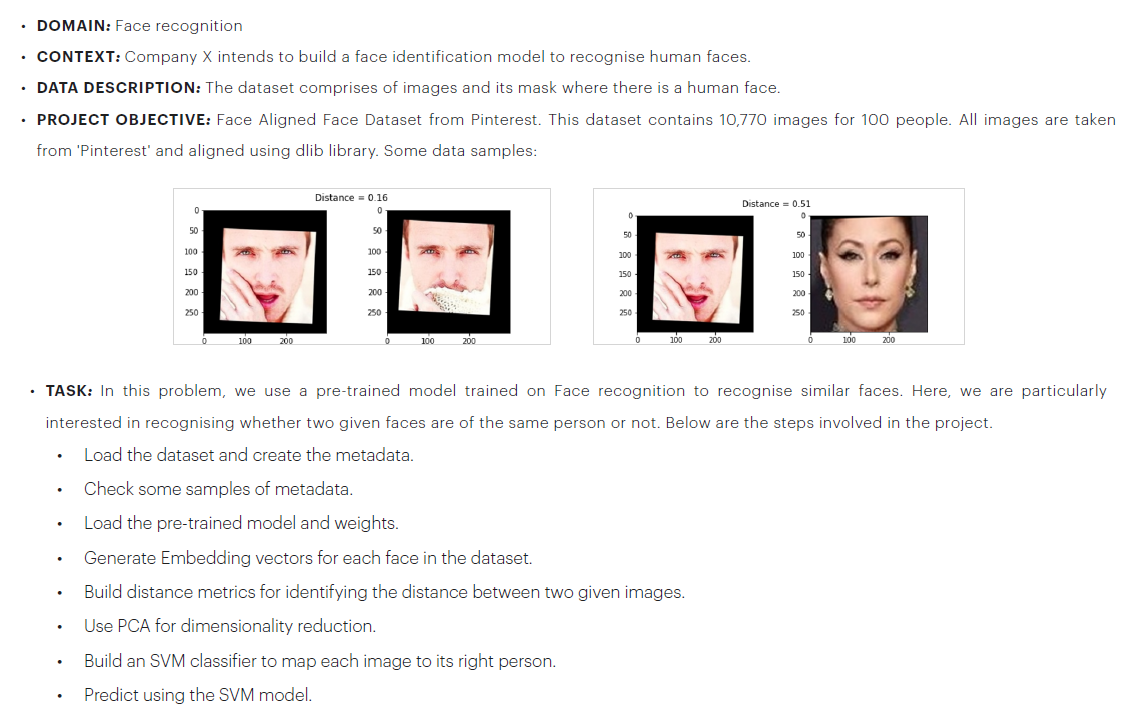

In [4]:
import h5py,os,glob
from zipfile import ZipFile


In [5]:
#location where data are present
directory = "D:/Datasets/CV_project_part_2/PINS/PINS"

In [6]:
#remaning the folders 
for filename in os.listdir(directory):
    filepath = os.path.join(directory, filename)
    newfilepath = os.path.join(directory, filename.replace("pins_", "").upper().replace(" ","_"))
    os.rename(filepath, newfilepath)

In [7]:
#generate class names
class_label = [] 
for filename in os.listdir(directory):
    class_label.append(filename)#.split('_')[1])
    
#class_label

In [8]:
len(class_label)

100

**Visualizing few images from each label**

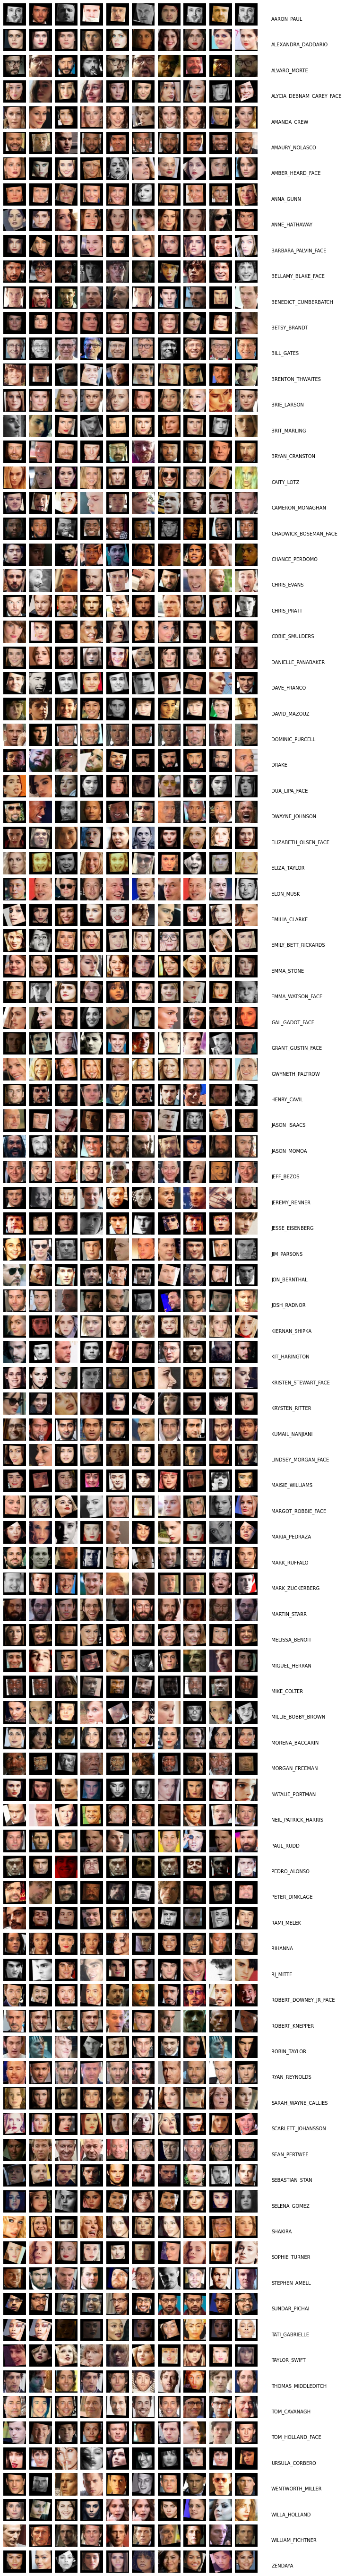

In [9]:
from mpl_toolkits.axes_grid1 import ImageGrid

fig = plt.figure(1, (300, 100))
grid = ImageGrid(fig, 111, nrows_ncols=(100, 10), axes_pad=0.1)

n_img_class = []
counter = 0
for idx, label in enumerate(class_label):
    paths = glob.glob(os.path.join(directory, label, "*.jpg"))
    n_img_class.append([label, len(paths)])
    perm = np.random.choice(len(paths), size=10)

    title = True
    for ii in perm:
        ax = grid[counter]
        if title:
            ax.text(1800, 105, label, verticalalignment="center")
            title = False
        img = cv2.imread(paths[ii])
        img = cv2.resize(img, (150, 150))
        ax.axis("off")
        ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        counter += 1
        
plt.show()

In [11]:
# creating list of all images
images = []
class_names=[]
missing=0
for class_folder_name in os.listdir(directory):
    #print(class_folder_name)
    for image_name in os.listdir(os.path.join(directory,class_folder_name)):
        image_path = os.path.join(directory,class_folder_name,image_name)
        image_bgr = cv2.imread(image_path, cv2.IMREAD_COLOR)
        # if the file contain any missing value ignore it add the count to  and we continue to next image
        if image_bgr is None: 
            missing += 1
            continue
        images.append(image_bgr)
        class_names.append(class_folder_name)

In [10]:
len(images)

10770

In [12]:
# resize image
def resize_images(img):
    img = np.array(img).astype(np.uint8)
    #print(img.dtype)
    res_img = cv2.resize(img,(224,224), interpolation = cv2.INTER_CUBIC)
    return res_img

#save resized images into images.
images = [resize_images(img) for img in images]

In [13]:
images[0].shape

(224, 224, 3)

In [14]:
from sklearn.preprocessing import LabelBinarizer

def generate_one_hot_encoding(classes):
    encoder = LabelBinarizer()
    transfomed_labels = encoder.fit_transform(classes)
    return transfomed_labels

labels = generate_one_hot_encoding(class_names)

### Function to load images
*Define a function to load the images from the extracted folder and map each image with person id

In [15]:
class IdentityMetadata():
    def __init__(self, base, name, file):
        # dataset base directory
        self.base = base
        # identity name
        self.name = name
        # image file name
        self.file = file

    def __repr__(self):
        return self.image_path()

    def image_path(self):
        return os.path.join(self.base, self.name, self.file) 
    
def load_metadata(path):
    metadata = []
    for i in os.listdir(path):
        for f in os.listdir(os.path.join(path, i)):
            metadata.append(IdentityMetadata(path, i, f))
    return np.array(metadata)

metadata = load_metadata(directory)

In [16]:
metadata[0]

D:/Datasets/CV_project_part_2/PINS/PINS\AARON_PAUL\Aaron Paul0_262.jpg

### Define function to load image
* Define a function to load image from the metadata

In [17]:
def load_image(path):
    img = cv2.imread(path, 1)
    # OpenCV loads images with color channels
    # in BGR order. So we need to reverse them
    return img[...,::-1]

load_image(str(metadata[0]))

array([[[233, 188, 165],
        [231, 186, 163],
        [220, 178, 156],
        ...,
        [106,  63,  72],
        [106,  63,  72],
        [106,  63,  72]],

       [[232, 187, 164],
        [233, 188, 165],
        [220, 178, 156],
        ...,
        [106,  63,  72],
        [106,  63,  72],
        [106,  63,  72]],

       [[230, 186, 161],
        [228, 184, 159],
        [206, 164, 140],
        ...,
        [106,  63,  72],
        [106,  63,  72],
        [106,  63,  72]],

       ...,

       [[198, 118,  91],
        [197, 120,  94],
        [195, 119,  95],
        ...,
        [ 78,  66,  76],
        [ 78,  66,  76],
        [ 78,  66,  76]],

       [[200, 120,  93],
        [200, 120,  93],
        [198, 121,  95],
        ...,
        [ 78,  66,  76],
        [ 78,  66,  76],
        [ 78,  66,  76]],

       [[201, 121,  94],
        [201, 121,  94],
        [199, 122,  96],
        ...,
        [ 78,  66,  76],
        [ 78,  66,  76],
        [ 78,  66,  76]]

In [18]:
#installing keras-vggface package
#!pip install keras-vggface
#!pip install Keras-Applications
!pip show keras-vggface

Name: keras-vggface
Version: 0.6
Summary: VGGFace implementation with Keras framework
Home-page: https://github.com/rcmalli/keras-vggface
Author: Refik Can MALLI
Author-email: mallir@itu.edu.tr
License: MIT
Location: c:\users\prem kumar\anaconda3\envs\tfod\lib\site-packages
Requires: scipy, pillow, h5py, six, keras, pyyaml, numpy
Required-by: 


In [19]:
import keras_vggface
# print version
print(keras_vggface.__version__)

0.6


if you face this error: **ModuleNotFoundError: No module named 'keras.engine.topology'**


In the keras_vggface/models.py file, change the import from:

* **from keras.engine.topology import get_source_inputs**

to:

* **from keras.utils.layer_utils import get_source_inputs**

In [22]:
weights_file =  "D:/Datasets/CV_project2/vgg_face_weights.h5"

### VGG Face model¶
* Here we are giving you the predefined model for VGG face

In [23]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import ZeroPadding2D,Convolution2D,MaxPooling2D
from tensorflow.keras.layers import Dense,Dropout,Softmax,Flatten,Activation,BatchNormalization
from tensorflow.keras.preprocessing.image import load_img,img_to_array
from tensorflow.keras.applications.imagenet_utils import preprocess_input
import tensorflow.keras.backend as K

# Define VGG_FACE_MODEL architecture
model = Sequential()
model.add(ZeroPadding2D((1,1),input_shape=(224,224, 3)))
model.add(Convolution2D(64, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(ZeroPadding2D((1,1)))	
model.add(Convolution2D(128, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(Convolution2D(4096, (7, 7), activation='relu'))
model.add(Dropout(0.5))
model.add(Convolution2D(4096, (1, 1), activation='relu'))
model.add(Dropout(0.5))
model.add(Convolution2D(2622, (1, 1)))
model.add(Flatten())
model.add(Activation('softmax'))

# Load VGG Face model weights
model.load_weights(weights_file)

### Get vgg_face_descriptor

In [24]:
from tensorflow.keras.models import Model
vgg_face_descriptor = Model(inputs=model.layers[0].input, outputs=model.layers[-2].output)

### Generate embeddings for each image in the dataset
* Given below is an example to load the first image in the metadata and get its embedding vector from the pre-trained model.

In [25]:
# Get embedding vector for first image in the metadata using the pre-trained model


def get_embedding_from_path(img_path):
    img = load_image(img_path)

    img = cv2.resize(img, dsize = (224,224))
    # Normalising pixel values from [0-255] to [0-1]: scale RGB values to interval [0,1]
    img = (img / 255.).astype(np.float32)
    #print(img.shape)

    # Obtain embedding vector for an image
    # Get the embedding vector for the above image using vgg_face_descriptor model and print the shape 
    return vgg_face_descriptor.predict(np.expand_dims(img, axis=0))[0]

img_path = metadata[0].image_path()
embedding_vector =  get_embedding_from_path(img_path)

print(embedding_vector.shape)

(2622,)


### Generate embeddings for all images 
* Write code to iterate through metadata and create embeddings for each image using vgg_face_descriptor.predict() and store in a list with name embeddings

* If there is any error in reading any image in the dataset, fill the emebdding vector of that image with 2622-zeroes as the final embedding from the model is of length 2622.

In [26]:
embeddings = np.zeros((metadata.shape[0], 2622))
print(embeddings.shape)


for i, m in enumerate(metadata):
    img_path = m.image_path()
    embeddings[i] =  get_embedding_from_path(img_path)

(10770, 2622)


In [28]:
#embeddings2 = [get_embedding_from_path(img_path) for m in metadata]

In [27]:
embeddings[2]

array([ 0.02801892, -0.0011263 , -0.01265749, ..., -0.00904751,
       -0.00578402,  0.02125832])

### Function to calculate distance between given 2 pairs of images.¶
* Consider distance metric as "Squared L2 distance"
* Squared l2 distance between 2 points (x1, y1) and (x2, y2) = (x1-x2)^2 + (y1-y2)^2

In [30]:
def distance(emb1, emb2):
    return np.sum(np.square(emb1 - emb2))

### Plot images and get distance between the pairs given below
* 2, 3 and 2, 180
* 30, 31 and 30, 100
* 70, 72 and 70, 115

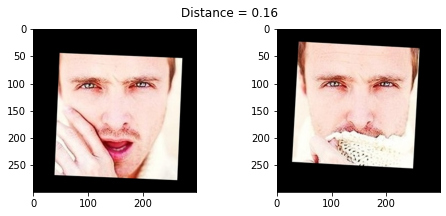

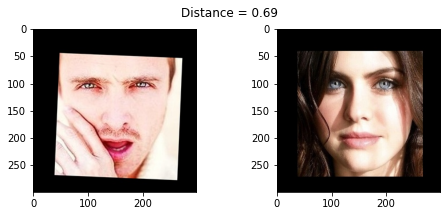

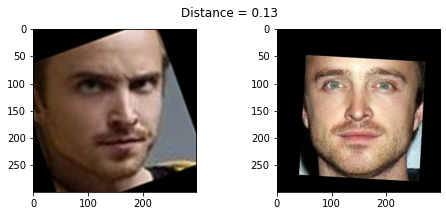

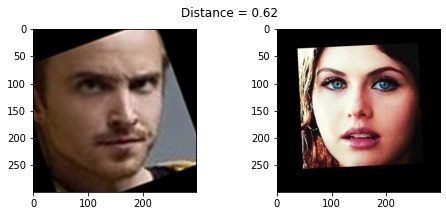

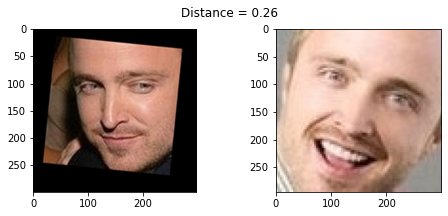

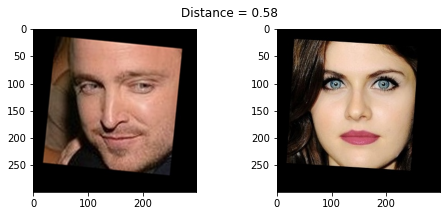

In [31]:
def show_pair(idx1, idx2):
    plt.figure(figsize=(8,3))
    plt.suptitle(f'Distance = {distance(embeddings[idx1], embeddings[idx2]):.2f}')
    plt.subplot(121)
    plt.imshow(load_image(metadata[idx1].image_path()))
    plt.subplot(122)
    plt.imshow(load_image(metadata[idx2].image_path()));    

show_pair(2, 3)
show_pair(2, 180)
show_pair(30, 31 )
show_pair(30, 100)
show_pair(70, 72)
show_pair(70, 115)

### Create train and test sets 
* Create X_train, X_test and y_train, y_test
* Use train_idx to seperate out training features and labels
* Use test_idx to seperate out testing features and labels

In [32]:
train_idx = np.arange(metadata.shape[0]) % 9 != 0     #every 9th example goes in test data and rest go in train data
test_idx = np.arange(metadata.shape[0]) % 9 == 0

# one half as train examples of 10 identities
X_train = embeddings[train_idx]
# another half as test examples of 10 identities
X_test = embeddings[test_idx]

targets = np.array([m.name for m in metadata])
#train labels
y_train = targets[train_idx]
#test labels
y_test = targets[test_idx]


In [33]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(9573, 2622)
(1197, 2622)
(9573,)
(1197,)


### Encode the Labels
* Encode the targets
* Use LabelEncoder

In [34]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(y_train)
y_train_le = le.transform(y_train)
y_test_le = le.transform(y_test)

In [35]:
y_train_le

array([ 0,  0,  0, ..., 99, 99, 99])

In [36]:
y_test_le

array([ 0,  0,  0, ..., 99, 99, 99])

In [37]:
embeddings[0].shape

(2622,)

### Standardize the feature values 
* Scale the features using StandardScaler

In [38]:
# Standarize features
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [47]:
X_train.shape

(9573, 2622)

In [48]:
X_test.shape

(1197, 2622)

### Reduce dimensions using PCA (3 marks)
* Reduce feature dimensions using Principal Component Analysis
* Set the parameter n_components=128

In [39]:
from sklearn.decomposition import PCA
X_train_pca = PCA(n_components=128,svd_solver  = 'randomized',whiten = True).fit(X_train)
#X_test_pca = PCA(n_components=128,svd_solver  = 'randomized',whiten = True).fit(X_test)

In [40]:
X_train_pca_data = X_train_pca.fit_transform(X_train)
X_test_pca_data = X_train_pca.transform(X_test)

In [41]:
print(X_train_pca_data.shape)
print(X_test_pca_data.shape)

(9573, 128)
(1197, 128)


### Build a Classifier 
* Use SVM Classifier to predict the person in the given image
* Fit the classifier and print the score

In [42]:
from sklearn.svm import SVC
from sklearn import metrics
clf = SVC(kernel = 'rbf',class_weight = None,C = 10,gamma = 'auto')
clf.fit(X_train_pca_data, y_train_le)


y_pred = clf.predict(X_test_pca_data)
svm_accuracy = metrics.accuracy_score(y_test_le, y_pred)

In [43]:
svm_accuracy

0.9640768588137009

### Test results (2 marks)
* Take 10th image from test set and plot the image
* Report to which person(folder name in dataset) the image belongs to

In [44]:
y_pred_10 = clf.predict([X_test_pca_data[10]])
y_pred_10

array([1])

(-0.5, 298.5, 298.5, -0.5)

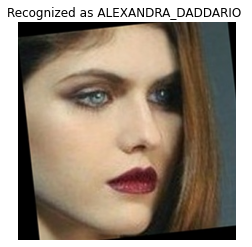

In [60]:
plt.imshow(load_image(metadata[test_idx][10].image_path()))
plt.title(f'Recognized as {le.inverse_transform(y_pred_10)[0]} ')
plt.axis('off')

**Prediction using SVM**

In [49]:
# preprocessing test image
def get_test_data(img_path,scaler,pca):
    img = get_embedding_from_path(img_path)
    img = sc.transform(img.reshape(1,-1))
    img = pca.transform(img)
    return img

In [52]:
img1 = load_image("D:/Datasets/CV_project2/Benedict_Cumberbatch9.jpg")
pred_img1 = get_test_data("D:/Datasets/CV_project2/Benedict_Cumberbatch9.jpg",sc,X_train_pca)
img2 = load_image("D:/Datasets/CV_project2/Dwayne_Johnson4.jpg")
pred_img2 = get_test_data("D:/Datasets/CV_project2/Dwayne_Johnson4.jpg",sc,X_train_pca)

In [54]:
pred_img1.shape

(1, 128)

In [55]:
pred_img2.shape

(1, 128)

[11]


(-0.5, 298.5, 298.5, -0.5)

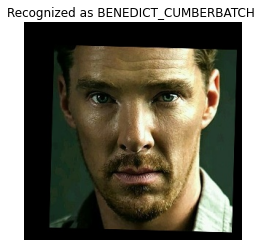

In [56]:
# image one
y_pred_1 = clf.predict(pred_img1)
print(y_pred_1)
plt.imshow(img1)
plt.title(f'Recognized as {le.inverse_transform(y_pred_1)[0]} ')
plt.axis('off')

[31]


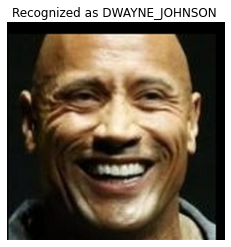

In [59]:
# image two
y_pred_2 = clf.predict(pred_img2)
print(y_pred_2)
plt.imshow(img2)
plt.title(f'Recognized as {le.inverse_transform(y_pred_2)[0]} ')
plt.axis('off')
plt.show()

# Conclusion
* Squared L2 distance was used to calculate the distance between 2 pairs of images.
* Encoding the target variables, standardizing the features and reducing dimensions using PCA.
* SVM classifier to predict the celebrity with 96.455% accuracy.